[View in Colaboratory](https://colab.research.google.com/github/steph1793/DeepNeuralNet/blob/master/DeepNeuralNet_FromScratch.ipynb)

# Deep Neural Network From Scratch

%%html
<img src="https://www.podcastscience.fm/wp-content/uploads/2015/09/Machine-Learning.jpg" width="600" >

In [0]:
import numpy as np
import math
import random


import gzip
import signal
import matplotlib.pyplot as plt


import tensorflow as tf # for mnist dataset

from random import randint



## MNIST dataset importation from tensorflow keras

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()


### We normalize and reshape the data

In [0]:
train_images, test_images = train_images/255.0, test_images/255.0
train_images = np.reshape(train_images, (-1,784))
test_images = np.reshape(test_images, (-1, 784))

In [0]:
def batches( x,y, batch_size):
  gather = list(zip(x,y))
  random.shuffle(gather)
  return [gather[i:i+batch_size] for i in range(0,len(gather),batch_size) ]

## Activations functions and their derivatives

In [0]:

def sigmoid(z):
  return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
  return sigmoid(z)*(1-sigmoid(z))

## Regularization functions

In [0]:
def L2(eta, lambd, training_size, weights):
  return (1 - eta*lambd /training_size)*weights

def L1(eta, lambd, training_size, weights):
  return (weights - eta*lambd/training_size*np.sign(weights))


## Cost functions sand their derivatives

In [0]:
def mse_derivative(z, a,y):
  return a-y

## Simple neural network class

By default we use sigmoid function as an activation function

In [0]:
class Network:
	def __init__(self, sizes):
		self.layer_num = len(sizes)
		self.sizes = sizes ## layers sizes
		self.default_weights_initializer()


	def default_weights_initializer(self):
		sizes = self.sizes
		self.weights = [ np.random.randn(sizes[i+1], sizes[i])/np.sqrt(sizes[1]) for i in range(len(sizes)-1)]
		self.biases = [np.random.randn(sizes[i]) for i in range(1, len(sizes))]

	def large_weights_initializer(self):
		sizes = self.sizes
		self.weights = [ np.random.randn(sizes[i+1], sizes[i]) for i in range(len(sizes)-1)]
		self.biases = [np.random.randn(sizes[i]) for i in range(1, len(sizes))]


	


	def feedforward(self, x, activation=sigmoid):
		a = x
		z_values = []
		a_values = []
		a_values.append(x)
		for w, b in list(zip(self.weights, self.biases)):
			z = np.dot(w, a) + b
			a = activation(z)
			a_values.append(a)
			z_values.append(z)
		return z_values, a_values



	def test(self, x):
		a = x
		for w,b in list(zip(self.weights, self.biases)):
		  a = sigmoid(np.dot(w,a)+b)
		return a



	def evaluate(self, test_data, test_labels):
		results = [(np.argmax(self.test(x)),y) for (x,y) in list(zip(test_data, test_labels))]
		return sum(int(x==y) for (x,y) in results)



## Optimizer class

In [0]:
class Optimizer:
  def __init__(self, net):
    self.net = net

  def backpropagate(self, z_values, out_err):
    deltas = []
    d = out_err
    deltas.append(d)
    for l in range(1,self.net.layer_num-1):
      d = np.multiply(np.dot(np.transpose(self.net.weights[-l]), d), sigmoid_derivative(z_values[-l-1]))
      deltas.append(d)
    return deltas


  def gradient_descent(self, batch_deltas, batch_a_values, eta, batch_size,training_size, regular):
    for l in range(1, self.net.layer_num):
      delta_w = 0
      delta_b = 0
      for deltas, a_values in list(zip(batch_deltas, batch_a_values)):
        d = deltas
        a = a_values[::-1]
        delta_w = delta_w + np.dot(np.asarray([d[l-1]]).transpose(), np.asarray([a[l]]))
        delta_b = delta_b + d[l-1]
      if not regular:
        self.net.weights[-l] = self.net.weights[-l] -eta/batch_size*delta_w
      else:
        self.net.weights[-l] = eval("{0}".format(regular[0]))(eta, regular[1], training_size, self.net.weights[-l]) - eta/batch_size*delta_w

      self.net.biases[-l] = self.net.biases[-l] - eta/batch_size*delta_b



  def Optimize(self, batch, eta, cost, training_size, regular):
    batch_deltas = []
    batch_a_values = []
    for x,y in batch:
      z_values, a_values = self.net.feedforward(x)
      out_err = cost(z_values[-1], a_values[-1],y)
      deltas = self.backpropagate(z_values, out_err)
      batch_deltas.append(deltas)
      batch_a_values.append(a_values)
    self.gradient_descent(batch_deltas, batch_a_values, eta, len(batch), training_size, regular)



## Training function

In [0]:
def train(network, optimizer, training_data, training_labels, batch_size, eta, epochs, test_data=[], test_labels=[], cost=mse_derivative, regular=[]):
  for epoch in range(epochs):
    bs = batches(training_data, training_labels, batch_size)
    for mini_batch in bs:
      optimizer.Optimize(mini_batch, eta,cost, len(training_data), regular)
    if test_data.any() and test_labels.any() :
                              print("Epoch {0} : Accuracy => {1} / {2}".format(epoch, network.evaluate(test_data, test_labels), len(test_data) ))
    else :
                              print("Epoch {0}".format(epoch))



## Labels encoding (to hot vectors) and decoding (to integers)

In [0]:

def encode_mnist_output(labels):
	return [ [0 if i != j else 1 for i in range(10)] for j in labels]


def decode_output(y):
  return np.argmax(y)

## We create network and optimizer objects

In [0]:
net = Network([784,100,10]) ## Here we define the number of layers and their sizes
optimizer = Optimizer(net)

## Model training

In [0]:
#@title Hyperparameters

Batch_size = 100 #@param {type:"number"}
learning_rate = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
Epochs_num = 10 #@param {type:"number"}
lambda_ = 5 #@param {type:"slider", min:0, max:10, step:0.1}
Regularizer = "L2" #@param ["L1", "L2"]


In [14]:
train(net, optimizer, np.asarray(train_images), encode_mnist_output(train_labels),Batch_size,learning_rate,Epochs_num, np.asarray(test_images), np.asarray(test_labels), regular=[Regularizer,lambda_])


Epoch 0 : Accuracy => 9136 / 10000
Epoch 1 : Accuracy => 9353 / 10000
Epoch 2 : Accuracy => 9434 / 10000
Epoch 3 : Accuracy => 9497 / 10000
Epoch 4 : Accuracy => 9552 / 10000
Epoch 5 : Accuracy => 9592 / 10000
Epoch 6 : Accuracy => 9619 / 10000
Epoch 7 : Accuracy => 9639 / 10000
Epoch 8 : Accuracy => 9649 / 10000
Epoch 9 : Accuracy => 9671 / 10000


## Testing the model

We choose randomly some images in the test dataset and test them

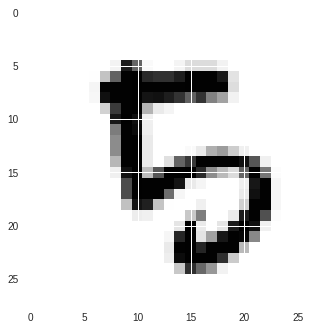

In [18]:
rand = randint(0,9999)
im=test_images[rand]
im = np.reshape(im, ( 28,28))
plt.imshow(im)

In [19]:
im = np.reshape(im, (784))
print("The decoded number")
print(decode_output(net.test(im)))

The decoded number
5


In [17]:
%%html
<marquee style='width: 100%; color: blue; font-size:50px;'><b>That's it !!</b></marquee>